# Stack Overflow Developer Survey 2019: Part I - Data Scientist Profile

## Outline:
0. Intro
1. Read in data
2. Subset data scientists 
3. Missing data
4. Data scientist profile
5. Key Observations and Conclusions

## 0. Intro 

Since 2011, Stack Overflow has been conducting the **"Stack Overflow Annual Developer Survey"**. As grad student and aspiring Data Scientist, I was interested in learning more about the **Data Scientist results** in this survey.

The Stack Overflow survey is very, very long. There are four main sections: **Developers Profile, Technology, Work, and Community**. My goal is ***roughly*** replicate the analysis offered by Stack Overflow in each section. I will skip a few plots, add a few that I found useful, and to offer additional commentaries and analysis.

This Jupyter Notebook contains my analysis for the first section of the survey: **Data Scientist Profile**. I developed all the analysis using Python, pandas, numpy, and plotly (for Bubble Maps). I intentionally avoided using additional Python graphical libraries (matplotlib, seaborn, etc.), just to practice and show how easily you can get an exploratory data analysis done in Python.

**My work is by no means perfect. Feel free to comment, share, extend, and improve the analysis/code/plots as you like!**

In [103]:
import pandas as pd
import numpy as np
import plotly.express as px
import pycountry

In [104]:
!python --version

Python 3.6.9 :: Anaconda, Inc.


In [105]:
!jupyter-notebook --version

6.0.1


In [106]:
print(f'Pandas version: {pd.__version__}, Numpy version: {np.__version__}')

Pandas version: 0.25.1, Numpy version: 1.16.4


## I. Read in data

We will read in the survey data using pandas read_csv function. Fortunately, the dataset seems to be very well organized so this is pretty straight forward to do.

In [107]:
df = pd.read_csv('../data/survey_results_public.zip', compression='zip')
df.head(2)

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult


In [108]:
df.shape

(88883, 85)

In [212]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [218]:
print(f'int64 count: {df.dtypes.apply(lambda x: x == "int64").sum()}')
print(f'float64 count: {df.dtypes.apply(lambda x: x == "float64").sum()}')
print(f'object count: {df.dtypes.apply(lambda x: x == "O").sum()}')

int64 count: 1
float64 count: 5
object count: 79


The survey dataset contains **88,883 rows and 85 columns**, with **6 numerical columns and 79 'object' columns**. When pandas returns a 'object' type usually means that the column (or 'Series' in pandas jargon) contains strings or a mix of data types. pandas does not allow for multiple data types in a Series, which is preciselly why pandas **upcast such columns to the type 'object'**, which is the more general data type in pandas. The 'mixing' usually comes from **combining strings cases with 'NaN' cases**, and 'NaN' values tuns out to be 'float' data types. Now let's find the variable that will help us to extract the Data Scientists from the survey.

In [222]:
df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
       'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
       'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
       'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
       'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
       'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
       'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
       'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife'

A quick glance to the column names suggest that **'Employment' or maybe 'DevType'** may contain what we are looking for. Let's subset and print out those columns. 

In [111]:
df[['Employment', 'DevType']][0:5]

,Employment,DevType
0,"Not employed, and not looking for work",NaN
1,"Not employed, but looking for work","Developer, desktop or enterprise applications;..."
2,Employed full-time,"Designer;Developer, back-end;Developer, front-..."
3,Employed full-time,"Developer, full-stack"
4,Employed full-time,"Academic researcher;Developer, desktop or ente..."


**'Devtype' contains what we are looking for**.

## 2. Subsetting Data Scientists

There are multiple ways to approach the data subsetting. If you are into text analysis, natural language processing and the likes, you may be a regular expression wizard, and solve this using regex. I have a particular distaste for memorizing regular expressions syntax which I happen to think is one of the most useful, yet, ugly abominations ever invented. Therefore, I'll take advantage of a few of Python tricks to get the job done. This is what I'm going to do:

1. Create a list of keyword to search within each string
2. Cast the DevType column into a list of strings
3. Search within each string in the list the keywords in my 'search' list
4. Return 'True' if ANY of the keywords is the string, and 'False' otherwise
5. Use the resulting boolean array of 'True' and 'False' values to filter the original dataframe

The way in which step 5 works, is simple: pandas will retain the rows where 'True' is passed, and drop the rest.

Note that **there isn't such a thing as a universally accepted way to define who is a Data Scientist**, so feel free to define your own keywords for search. For instance, I decided to not add *Database administrator*, which tend to overlap with back-end software engineers, but some people may consider them Data Scientist as well.

In [112]:
search = ['data scientist', 'data analyst', 'business analyst', 'machine learning'] # keywords to be searched
filter = list(df.DevType.astype(str)) # list to be filtered
mask = [True if search[0] in x.lower() or search[1] in x.lower() or search[2] in x.lower() or search[3] in x.lower() else False for x in filter] # boolean mask to retain keywords
df_mask = df[mask]
df_ds = df_mask.copy() # we create a new copy to avoid changing the raw data
df_ds.shape

(10675, 85)

In [113]:
df_ds.DevType.head(10)

5     Data or business analyst;Data scientist or mac...
9     Data or business analyst;Data scientist or mac...
11    Data or business analyst;Data scientist or mac...
12    Data or business analyst;Database administrato...
17                             Data or business analyst
21    Data or business analyst;Designer;Developer, b...
32    Academic researcher;Data scientist or machine ...
41    Academic researcher;Data or business analyst;D...
50       Data or business analyst;Developer, full-stack
58    Data or business analyst;Database administrato...
Name: DevType, dtype: object

We obtained a dataframe with **10,675** rows where people mentioned **at least one** of our keywords. At this point we can eyeball that **1/8 or ~12%** of the respondent self-identify as Data Scientist, which looks a pretty decent sample size for our analysis.

## II. Missing Data

Cheking for missing values is standard practice, particularly in hypothesis testing, machine learning, or predictive modeling. Some people may prefer to do this only under the aforementioned circumstances, but I consider **this is important for exploratory data analysis as well**. If you find patterns of missing data, for instance, by gender, data might offer a misleading representation of the population. pandas makes this very simple.

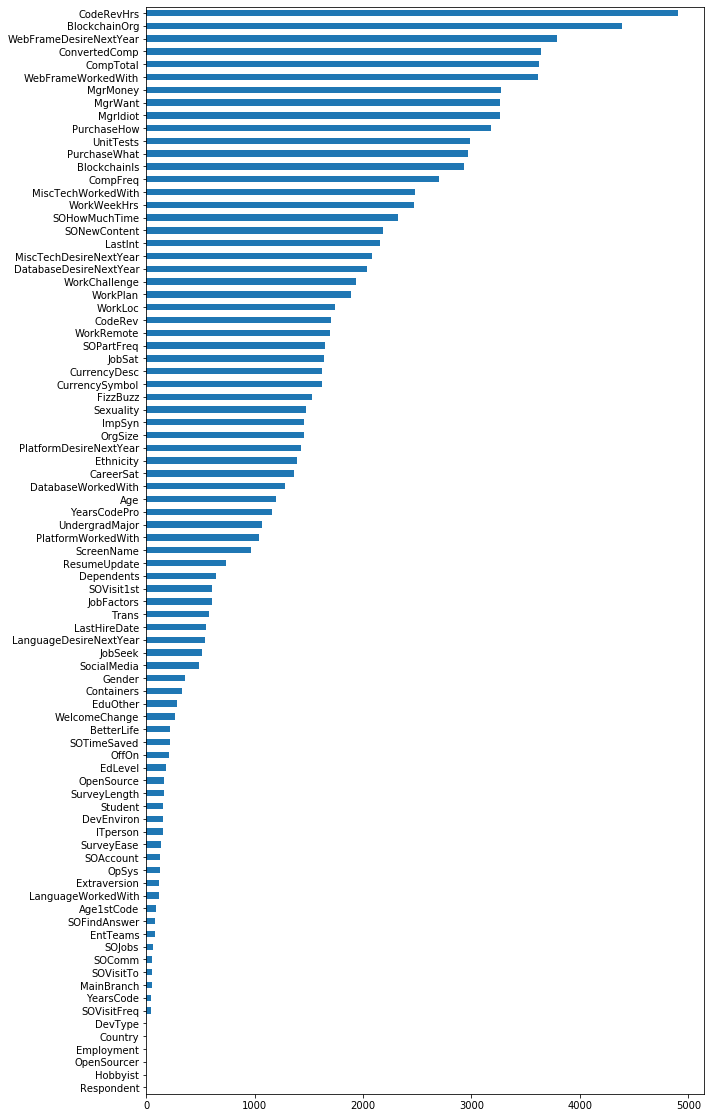

In [114]:
df_ds.isnull().sum().sort_values(ascending=True).plot(kind='barh', figsize=(10, 20));

The barplot display the number of rows with missing values. We see that *CodRevHrs* has almost 5,000 missing values, which is around 50% of the data. **Only 5 features have zero missing values**. In general, it seems to be a lot of missing values in most variables, which calls for precaution when interpreting results from this survey for some variables.  

Before proceding, **a note about plots in Python**: I often read/hear R users mentioning that ploting in Python is harder. I think that such impression can be a product of two things: first, comparing Matplotlib and ggplot2. Matplotlib is verbose and uses a different philosophy than ggplot2, which makes it unintuitive for R users; second, simpler ways to make plots (like the out-of-the-box functionality of Pandas) are often unknown. As an exercise, I'll avoid using Matplotlib, Seaborn, or Altair, and **I'll restric myself to pandas default plot functionality**. The only exception will be using plotly.express to create Bubble Maps.

## III. Data Scientist Profile

Our goal is to characterize Data Scientist's profiles by **roughly reproducing the StackOverflow results for all Developers in 2019**. You can find the 2019 results here https://insights.stackoverflow.com/survey/2019#overview 

Most features in the survey are text. Text makes data exploration a bit complicated, because it requires extra data wrangling before plotting. I will create a few functions for plotting using pandas default functionality. 

In [223]:
def bar_plot_percent(series: str, kind: str ='barh', title: str = 'Title', order=None, sort=False, size=None, df=df_ds):
    '''Plot a series
    
    Arguments:
    ----------
    series(str)   -- series to be plot (default None)
    kind(str)     -- type of plot (default barh)
    title(str)    -- plot title (defaul 'Title')
    order(list)   -- apply custom order (default None)
    sort(bool)    -- sort in descending order (default False)
    size(tuple)   -- width and hight dimensions (default None)
    df(DataFrame) -- DataFrame to be plot (default df_ds)
    
    Returns:
    --------
    plot
    '''
    if sort:
        return df[series].value_counts().apply(lambda x: np.round((x/df[series].notna().sum())*100, decimals=2)).reindex(order).sort_values(ascending = sort).plot(kind=kind, figsize=size, title=title);
    else:
        return df[series].value_counts().apply(lambda x: np.round((x/len(df))*100, decimals=2)).reindex(order).plot(kind=kind, figsize=size, title=title);

In [225]:
def get_percent(series: str, df=df_ds):
    '''Compute percentage for a series
    
    Arguments:
    ----------
    series(str)   -- series to be computed
    df(DataFrame) -- Drataframe
    
    Returns:
    --------
    Percentage for series'''
    return df[series].value_counts().apply(lambda x: np.round((x/df[series].notna().sum())*100, decimals=2))

### I. Geography

The Stack Overflow survey was answered by developers from all over the world. In the case of Data Scientist, we found respondents from **143 countries**, but the bulk of the data comes from a few countries. To better understand this, we will create an **interactive bubble map** using *plotly*. One inconvinience, is the requirement of **ISO Alpha 3** codes for each country (i.e., the standard 3 letter code). Fortunately, we can use the *pycountry* library to map country names to ISO Alpha 3 codes. Unfortunately, *pycountry* requires the official name of each country to work, and some countries are named incorrectly. As painful as it was, I checked and replaced each country name with the correct one below.

In [117]:
df_ds.Country.replace({
    'Iran':'Iran, Islamic Republic of',
    'Czech Republic':'Czechia',
    'Taiwan':'Taiwan, Province of China',
    'Hong Kong (S.A.R.)':'Hong Kong',
    'South Korea': 'Korea, Republic of',
    'United Republic of Tanzania':'Tanzania, United Republic of',
    'Venezuela, Bolivarian Republic of...':'Venezuela, Bolivarian Republic of',
    'The former Yugoslav Republic of Macedonia':'North Macedonia',
    'Bolivia':'Bolivia, Plurinational State of',
    'Libyan Arab Jamahiriya':'Libya',
    'Republic of Moldova':'Moldova, Republic of',
    'Democratic Republic of the Congo':'Congo',
    'Republic of Korea': 'Korea, Republic of',
    'Congo, Republic of the...': 'Congo',
    "Democratic People's Republic of Korea":"Korea, Democratic People's Republic of"
                       }, inplace=True)

To create the Bubble Map, we need to create a country dataframe, with country, percentage, and frequency

In [118]:
mask_countries = (df_ds.Country != 'Other Country (Not Listed Above)') # exclude unknown countries
countries_plot = get_percent('Country', df_ds[mask_countries]).to_frame() # add percentage by country
countries_plot['countries'] = countries_plot.index # add country column
countries_plot_2 = countries_plot.merge(df_ds.Country.value_counts().to_frame(), left_index=True, right_index=True) # add frequency by country
countries_plot_2.rename(columns={"Country_x": "percentage", "Country_y": "frequency"}, inplace=True)
countries_plot_2.head()

,percentage,countries,frequency
United States,27.17,United States,2897
India,9.12,India,972
Germany,6.33,Germany,675
United Kingdom,5.87,United Kingdom,626
Canada,3.63,Canada,387


As we mentioned, we will add the **ISO Alpha 3** using the ```pycountry.countries.get method```

In [119]:
countries_plot_2["iso_alpha"] = countries_plot.countries.apply(lambda x: pycountry.countries.get(name=x).alpha_3)
countries_plot_2.head()

,percentage,countries,frequency,iso_alpha
United States,27.17,United States,2897,USA
India,9.12,India,972,IND
Germany,6.33,Germany,675,DEU
United Kingdom,5.87,United Kingdom,626,GBR
Canada,3.63,Canada,387,CAN


##### Bubble Map of Data Scientist by Country as Percentage
If you hover over the bubble on each country, you will get the country name and information

In [120]:
fig = px.scatter_geo(countries_plot_2, locations="iso_alpha",
                     hover_name="countries", size="percentage", color="percentage",
                     projection="natural earth")
fig.show()

##### Bubble Map of Data Scientist by Country as Frequency
You can zoom in, zoom out, and move the map around to explore

In [121]:
fig = px.scatter_geo(countries_plot_2, locations="iso_alpha",
                     hover_name="countries", size="frequency", color="frequency",
                     projection="natural earth")
fig.show()

Our maps indicates that survey participant's come primarily from the **US, Canada, Western Europe, India, and Australia**. Participation from Central America, South America, and Africa is minor.

#### Montly Stack Overflow Visits

We don't have access to the number of visits by country in the survey. Nonetheless, participant did report how often they visit Stack Overflow.

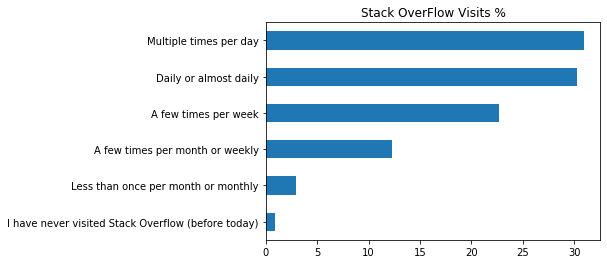

In [226]:
bar_plot_percent('SOVisitFreq', 'barh', 'Stack OverFlow Visits %', sort=True);

In [122]:
get_percent('SOVisitFreq')

Multiple times per day                                30.97
Daily or almost daily                                 30.23
A few times per week                                  22.65
A few times per month or weekly                       12.26
Less than once per month or monthly                    2.99
I have never visited Stack Overflow (before today)     0.89
Name: SOVisitFreq, dtype: float64

Around **61% of participants report visiting Stack Overflow every day**. This is hardly surprising since is the Stack Overflow survey!

### Data Scientist Role

#### Contributing to Open Source

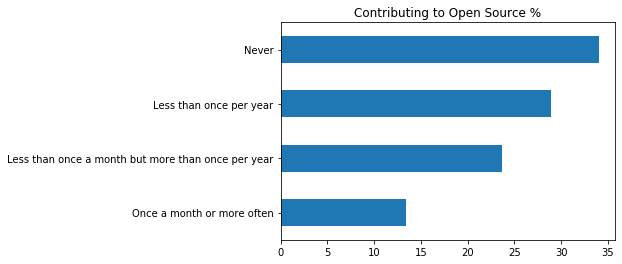

In [224]:
bar_plot_percent('OpenSourcer', 'barh', 'Contributing to Open Source %', sort=True);

In [124]:
get_percent('OpenSourcer')

Never                                                 34.09
Less than once per year                               28.88
Less than once a month but more than once per year    23.66
Once a month or more often                            13.37
Name: OpenSourcer, dtype: float64

Over **~37% of Data Scientists report to contribute to open source more than once per year**, and **13.37% once a month or more often**. This percentages are remarkably similar to the numbers for the whole developers sample reported by Stack Overflow (~25% and ~12% respectively)

#### Coding as a Hobby

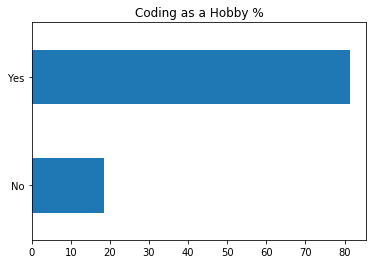

In [125]:
bar_plot_percent('Hobbyist', 'barh', 'Coding as a Hobby %', sort=True);

In [126]:
get_percent('Hobbyist')

Yes    81.49
No     18.51
Name: Hobbyist, dtype: float64

**~81% of Data Scientists report to code as a hobby**, again very close to the ~80% from the whole developer's sample. 

### Experience

#### Years Since Learning to Code

Here we have an interesting problem. There is a **mix of intergers and strings types**. Casting everything to numerical won't work, unless we handle the non-numerical values firts. I'll map *'Less than 1 year'* to 1 and *'More than 50 years'* to 51.This will work for us since we will partition the data into broader groups later.

In [127]:
df_ds.YearsCode.unique()

array(['13', '12', '5', '17', '10', '35', '6', '8', '4', '25', '1', '30',
       '3', '7', '41', '16', '20', '22', '18', '23', '21', '19', '14',
       '32', '27', '2', '9', '15', '40', '33', '11', '26',
       'Less than 1 year', '24', '37', nan, '28', '34', '29', '36', '45',
       '46', '31', '38', 'More than 50 years', '48', '39', '42', '50',
       '47', '43', '44', '49'], dtype=object)

In [128]:
df_ds.YearsCode.replace({'Less than 1 year': 1, 'More than 50 years': 51}, inplace=True)

We cast everything to float to create the age ranges with conditional logic

In [129]:
df_ds.YearsCode = df_ds.YearsCode.astype('float64')

In [130]:
conditions_years = [
    (df_ds['YearsCode'] < 5),
    (df_ds['YearsCode'] >= 5) & (df_ds['YearsCode'] <= 9),
    (df_ds['YearsCode'] >= 10) & (df_ds['YearsCode'] <= 14),
    (df_ds['YearsCode'] >= 15) & (df_ds['YearsCode'] <= 19),
    (df_ds['YearsCode'] >= 20) & (df_ds['YearsCode'] <= 24),
    (df_ds['YearsCode'] >= 25) & (df_ds['YearsCode'] <= 29),
    (df_ds['YearsCode'] >= 30) & (df_ds['YearsCode'] <= 34),
    (df_ds['YearsCode'] >= 35) & (df_ds['YearsCode'] <= 39),
    (df_ds['YearsCode'] >= 40) & (df_ds['YearsCode'] <= 44),
    (df_ds['YearsCode'] >= 45) & (df_ds['YearsCode'] <= 49),
    (df_ds['YearsCode'] >= 50)
    ]

categories_years = [
    '5 years or less', '5 to 9 years', '10 to 14 years', '15 to 19 years',
    '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', 
    '40 to 44 years', '45 to 49 years', '50 years or more'
    ]

df_ds['YearsCodeR'] = np.select(conditions_years, categories_years)

A bunch of zeros will be generated, so we will replace those witn NaN values before ploting

In [131]:
df_ds.YearsCodeR.replace({'0': np.nan}, inplace=True)

We then obtain the following

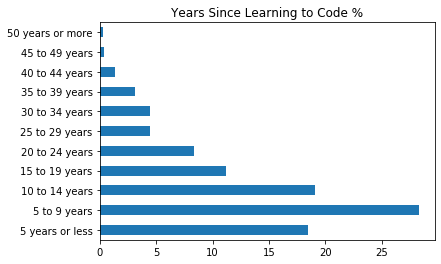

In [132]:
bar_plot_percent('YearsCodeR', 'barh', 'Years Since Learning to Code %', order=categories_years);

In [133]:
get_percent('YearsCodeR')

5 to 9 years        28.38
10 to 14 years      19.18
5 years or less     18.58
15 to 19 years      11.27
20 to 24 years       8.42
30 to 34 years       4.52
25 to 29 years       4.49
35 to 39 years       3.15
40 to 44 years       1.36
45 to 49 years       0.40
50 years or more     0.25
Name: YearsCodeR, dtype: float64

The pattern of years since learning to code is basically identical to the one reported by all developers. Is often said that it has been an explotion in Data Science interest in the last decade or so. **~47% of Data Scientists report having learned to code in the last 9 years**, which is slightly less than the ~51% for all developers.

#### Years Coding Professionally

Years coding professionlly has the same issues found in Years Coding, so we will repeat the steps.

In [134]:
df_ds.YearsCodePro.unique()

array(['3', '10', nan, '8', '18', '5', '13', '1', '25', '2', '6', '4',
       '35', '11', '7', '20', '9', '16', '21', '30', 'Less than 1 year',
       '17', '15', '19', '37', '12', '23', '40', '22', '29', '24', '45',
       '32', '14', '43', '34', 'More than 50 years', '26', '33', '44',
       '36', '28', '27', '31', '50', '42', '39', '38', '41', '46', '47'],
      dtype=object)

In [135]:
df_ds.YearsCodePro.replace({'Less than 1 year': 1, 'More than 50 years': 51}, inplace=True)

In [136]:
df_ds.YearsCodePro = df_ds.YearsCodePro.astype('float64')

In [137]:
df_ds['YearsCodeProR'] = np.select(conditions_years, categories_years)

In [138]:
df_ds.YearsCodeProR.replace({'0': np.nan}, inplace=True)

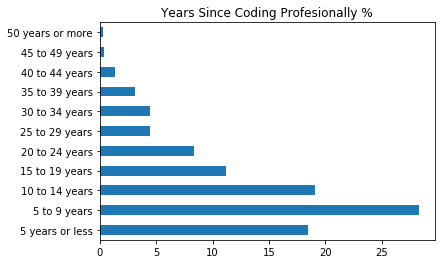

In [139]:
bar_plot_percent('YearsCodeProR', 'barh', 'Years Since Coding Profesionally %', order=categories_years);

In [140]:
get_percent('YearsCodeProR')

5 to 9 years        28.38
10 to 14 years      19.18
5 years or less     18.58
15 to 19 years      11.27
20 to 24 years       8.42
30 to 34 years       4.52
25 to 29 years       4.49
35 to 39 years       3.15
40 to 44 years       1.36
45 to 49 years       0.40
50 years or more     0.25
Name: YearsCodeProR, dtype: float64

Here we found an interesting patter. **Only ~18% of Data Scientists report less than 5 years of coding professionally**. This number is **~41% for all developers**. This may be an indication of many things: a bias in age group respondent in Data Scientists (older), maybe catalized by the need for additional years of training before entering the industry; or maybe is just the cycle of recruitment of new Data Scientists is slower than for developers in general. Many options.

#### Writing That First Line of Code

Here we have the same problems as in the previous cases, so we will repeat the steps again. One caveat is that now we need to redefine age ranges (i.e., change conditions and categories)

In [141]:
df_ds.Age1stCode.unique()

array(['15', '20', '16', '11', '18', '12', '9', '14', '7', nan, '10',
       '17', '19', '13', '33', '22', '30', 'Younger than 5 years', '24',
       '8', '21', '26', '5', '23', '25', '6', '29', '31', '28', '34',
       '32', '35', '27', 'Older than 85', '50', '43', '56', '45', '36',
       '79', '39', '40', '42', '37', '65', '38', '41', '51', '61', '44'],
      dtype=object)

In [142]:
df_ds.Age1stCode.replace({'Younger than 5 years': 4, 'Older than 85': 86}, inplace=True)

In [143]:
df_ds.Age1stCode = df_ds.Age1stCode.astype('float64')

In [144]:
conditions_age = [
    (df_ds['Age1stCode'] < 10),
    (df_ds['Age1stCode'] >= 10) & (df_ds['Age1stCode'] <= 11),
    (df_ds['Age1stCode'] >= 12) & (df_ds['Age1stCode'] <= 13),
    (df_ds['Age1stCode'] >= 14) & (df_ds['Age1stCode'] <= 15),
    (df_ds['Age1stCode'] >= 16) & (df_ds['Age1stCode'] <= 17),
    (df_ds['Age1stCode'] >= 18) & (df_ds['Age1stCode'] <= 19),
    (df_ds['Age1stCode'] >= 20) & (df_ds['Age1stCode'] <= 21),
    (df_ds['Age1stCode'] >= 22) & (df_ds['Age1stCode'] <= 23),
    (df_ds['Age1stCode'] >= 24) & (df_ds['Age1stCode'] <= 25),
    (df_ds['Age1stCode'] >= 26) & (df_ds['Age1stCode'] <= 27),
    (df_ds['Age1stCode'] >= 28) & (df_ds['Age1stCode'] <= 29),
    (df_ds['Age1stCode'] >= 50)
    ]

categories_age = [
    'Younger than 10 years', '10 to 11 years old', '12 to 13 years old', '14 to 15 years old',
    '16 to 17 years old', '18 to 19 years old', '20 to 21 years old', '22 to 23 years old', 
    '24 to 25 years old', '26 to 27 years old', '28 to 29 years old', '30 years old or older'
    ]

df_ds['Age1stCodeR'] = np.select(conditions_age, categories_age)

In [145]:
df_ds.Age1stCodeR.replace({'0': np.nan}, inplace=True)

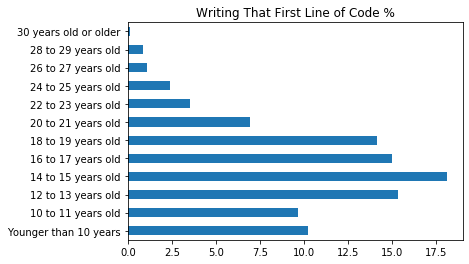

In [146]:
bar_plot_percent('Age1stCodeR', 'barh', 'Writing That First Line of Code %', order=categories_age);

In [147]:
get_percent('Age1stCodeR')

14 to 15 years old       18.58
12 to 13 years old       15.75
16 to 17 years old       15.42
18 to 19 years old       14.51
Younger than 10 years    10.51
10 to 11 years old        9.91
20 to 21 years old        7.11
22 to 23 years old        3.64
24 to 25 years old        2.43
26 to 27 years old        1.13
28 to 29 years old        0.87
30 years old or older     0.15
Name: Age1stCodeR, dtype: float64

The distribution for this variable looks very similar to the one for all developers. Roughly **68% of Data Scientists mentioned that they wrote that first line of code as kids** (i.e., 17 years or less). I find this to be very surprising, since I often read or hear Data Scientists saying that they learned to code in college or grad school. As a personal note, depending how you count, **I am among a tiny ~2% minority of people who wrote that first line at age 25 or older** Yikes!

###  Education

#### How Many Developers are Students?

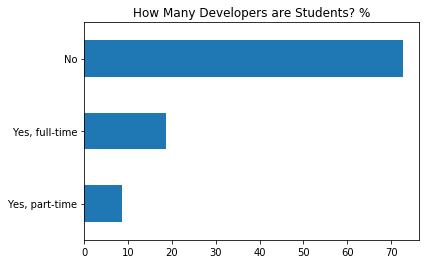

In [148]:
bar_plot_percent('Student', 'barh', 'How Many Developers are Students? %', sort=True);

In [149]:
get_percent('Student')

No                72.77
Yes, full-time    18.70
Yes, part-time     8.54
Name: Student, dtype: float64

**Around 27% report to be part-time or full time student**. This is very similar to the numbers for the developers full sample.

#### Educational Attainment

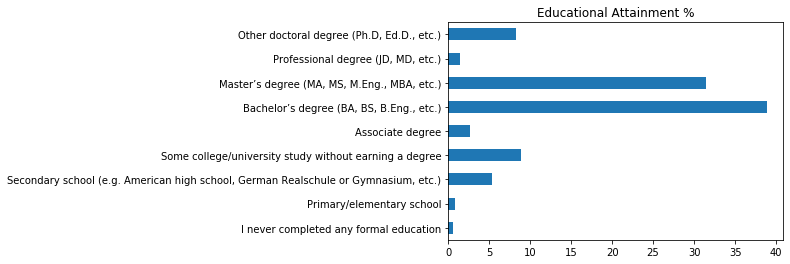

In [150]:
order_ed = [
    'I never completed any formal education', 'Primary/elementary school',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
    'Some college/university study without earning a degree',
    'Associate degree',
    'Bachelor’s degree (BA, BS, B.Eng., etc.)',
    'Master’s degree (MA, MS, M.Eng., MBA, etc.)',
    'Professional degree (JD, MD, etc.)',
    'Other doctoral degree (Ph.D, Ed.D., etc.)'
    ]
bar_plot_percent('EdLevel', 'barh', 'Educational Attainment %', order=order_ed);

In [151]:
get_percent('EdLevel')

Bachelor’s degree (BA, BS, B.Eng., etc.)                                              39.57
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           31.94
Some college/university study without earning a degree                                 9.09
Other doctoral degree (Ph.D, Ed.D., etc.)                                              8.38
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     5.41
Associate degree                                                                       2.66
Professional degree (JD, MD, etc.)                                                     1.47
Primary/elementary school                                                              0.88
I never completed any formal education                                                 0.60
Name: EdLevel, dtype: float64

The rumors are true! **Data Scientists are highly educated: ~81% have BA or higher**,**~42% have MA or higher**, and **~10% professional degrees and PhD**. This is **sharp contrast with developers in general who report ~72%, ~26%, and ~4%, respectively**. If spending a long time in school it is not your idea of fun, you might get more bang for your buck (and time) going into a different area than Data Science.

#### Undergraduate Major

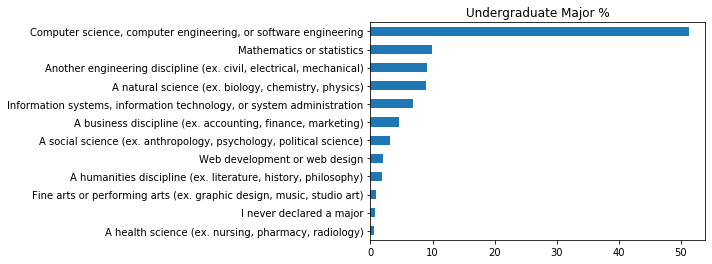

In [152]:
bar_plot_percent('UndergradMajor', 'barh', 'Undergraduate Major %', sort=True);

In [153]:
get_percent('UndergradMajor')

Computer science, computer engineering, or software engineering          51.34
Mathematics or statistics                                                 9.91
Another engineering discipline (ex. civil, electrical, mechanical)        9.06
A natural science (ex. biology, chemistry, physics)                       8.91
Information systems, information technology, or system administration     6.83
A business discipline (ex. accounting, finance, marketing)                4.58
A social science (ex. anthropology, psychology, political science)        3.19
Web development or web design                                             2.05
A humanities discipline (ex. literature, history, philosophy)             1.81
Fine arts or performing arts (ex. graphic design, music, studio art)      0.96
I never declared a major                                                  0.78
A health science (ex. nursing, pharmacy, radiology)                       0.58
Name: UndergradMajor, dtype: float64

**Computer science and engineering dominates undergraduate majors with ~51%**, but a at a lesser extent than in developers in general (~62%). **Math/Statistics/Engineering majors have a great presence too with ~19%**. Another personal note, I'm among that sad tiny minority of **3.19% individuals with social sciences majors**, Oh boy!

#### Other Types of Education

This feature is a string of multiple answers concatenated by a ';'. This is a bit tricky to plot, and there many ways to approch this. My approach will be:

- Declare a list of strings, with the categories to be counted
- Declare a empty dictionary to count occurrences of each category
- Loop over each category, applying a lambda function to split each string by ';', and get the total count for each category. 
- Re-asign to the empty dictionary, and make it into a pandas dataframe

In [154]:
c = [
    'Taught yourself a new language, framework, or tool without taking a formal course',
    'Taken an online course in programming or software development (e.g. a MOOC)',
    'Contributed to open source software',
    'Received on-the-job training in software development',
    'Participated in a hackathon',
    'Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)',
    'Taken a part-time in-person course in programming or software development',
    'Participated in a full-time developer training program or bootcamp',
    'Completed an industry certification program (e.g. MCPD)'
]

tmp = {}

In [155]:
for s in c:
    tmp[s] = (df_ds.EduOther.apply(lambda x: (str(x).split(';')).count(s))).sum()

In [156]:
ed_df = pd.DataFrame.from_dict(tmp, orient='index')

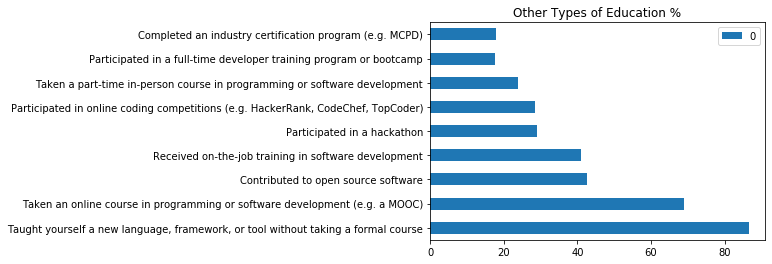

In [157]:
ed_df.apply(lambda x: np.round((x/df_ds.EduOther.notna().sum())*100, decimals=2)).plot(kind='barh', title='Other Types of Education %');

In [158]:
ed_df.apply(lambda x: np.round((x/df_ds.EduOther.notna().sum())*100, decimals=2))

,0
"Taught yourself a new language, framework, or tool without taking a formal course",86.61
Taken an online course in programming or software development (e.g. a MOOC),69.09
Contributed to open source software,42.63
Received on-the-job training in software development,40.88
Participated in a hackathon,29.03
"Participated in online coding competitions (e.g. HackerRank, CodeChef, TopCoder)",28.45
Taken a part-time in-person course in programming or software development,23.77
Participated in a full-time developer training program or bootcamp,17.72
Completed an industry certification program (e.g. MCPD),17.92


Self-education is very common among Data Scientists in the survey, with **~86% saying that they self-taught** some new language, framework, or tool, and **~69% that they have taken some MOOC**. This numbers are very similar to the whole sample of developers.

### Demographics

#### Race and Ethnicity

Race and Ethnicity are particularly complicated, since people may identify as belonging to multiple groups. By inspecting the data, looks like people were **allowed to select multiple groups**. This is, of course, the best choice in terms of accuracy, but makes analysis almost imposible without making hard and arbitrary choices regarding how to group people into buckets. You might be thinking: **"Can you just categorize as multiracial/multiethnic to people that selected multiple options"?** Absolutely. This would have been a great option. Unfortunately, **people did selected multiracial and *at the same time* other optins like Biracial, White, Middle Estern, etc.** In fact, there are *123 unique combinatios* of races/ethnicities in the survey. If we lump together as *multiracial* to people that chose multiple groups, Black or of African descent will get nulified as a group. If we apply the same logic applied to 'Other types of education' were will be double counting responses: if I selected Latino and Biracial, my answer will contribute to the total of both responses. 

What to do? I'll go with the double counting. I think this option respect people choices (to some degree) and makes our visualization cleaner.

In [159]:
c = [
    'White or of European descent',
    'South Asian',
    'Hispanic or Latino/Latina',
    'East Asian',
    'Middle Eastern',
    'Black or of African descent',
    'Multiracial',
    'Biracial',
    'Native American, Pacific Islander, or Indigenous Australian'
    ]

tmp = {}

In [160]:
for s in c:
    tmp[s] = (df_ds.Ethnicity.apply(lambda x: (str(x).split(';')).count(s))).sum()

In [161]:
et_df = pd.DataFrame.from_dict(tmp, orient='index')

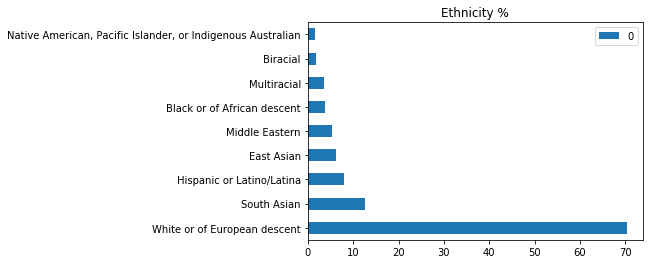

In [162]:
et_df.apply(lambda x: np.round((x/df_ds.Ethnicity.notna().sum())*100, decimals=2)).plot(kind='barh', title='Ethnicity %');

In [163]:
et_df.apply(lambda x: np.round((x/df_ds.Ethnicity.notna().sum())*100, decimals=2))

,0
White or of European descent,70.31
South Asian,12.57
Hispanic or Latino/Latina,7.99
East Asian,6.12
Middle Eastern,5.37
Black or of African descent,3.89
Multiracial,3.50
Biracial,1.91
"Native American, Pacific Islander, or Indigenous Australian",1.62


Again, race and ethnicity looks pretty similar to the reported for the full sample. People from **white and european ancestry dominate the sample with 70%**, followed by people from **south asia (mostly from India) with 12.57%**.

#### Gender

Gender is as complex as ethnicity. Again, people selected multiple choices. We will group people into three categories: **Woman, Man, and Non-binary, genderqueer, or gender non-conforming**.

In [164]:
df_ds['Gender2'] = df_ds.Gender.replace({
    'Man;Non-binary, genderqueer, or gender non-conforming': 'Non-binary, genderqueer, or gender non-conforming',
    'Woman;Man': 'Non-binary, genderqueer, or gender non-conforming',
    'Woman;Man;Non-binary, genderqueer, or gender non-conforming': 'Non-binary, genderqueer, or gender non-conforming',
    'Woman;Non-binary, genderqueer, or gender non-conforming': 'Non-binary, genderqueer, or gender non-conforming'
              })

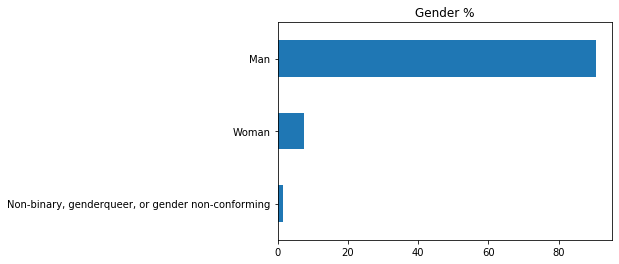

In [165]:
bar_plot_percent('Gender2', 'barh', 'Gender %', sort=True);

In [166]:
get_percent('Gender2')

Man                                                  90.72
Woman                                                 7.63
Non-binary, genderqueer, or gender non-conforming     1.65
Name: Gender2, dtype: float64

**Males completely dominate the sample with ~91%**, pretty similar to the ~92 for the entire sample

#### Experience and Gender

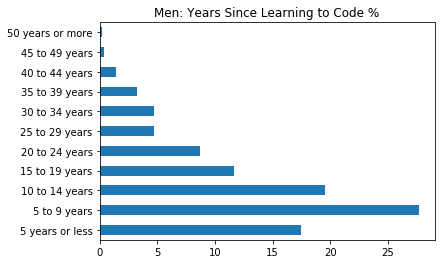

In [167]:
bar_plot_percent('YearsCodeR', 'barh', 'Men: Years Since Learning to Code %', order=categories_years, df=df_ds[df_ds['Gender'] == 'Man']);

In [168]:
get_percent('YearsCodeR', df=df_ds[df_ds['Gender'] == 'Man'])

5 to 9 years        27.72
10 to 14 years      19.58
5 years or less     17.52
15 to 19 years      11.68
20 to 24 years       8.70
25 to 29 years       4.72
30 to 34 years       4.72
35 to 39 years       3.27
40 to 44 years       1.45
45 to 49 years       0.41
50 years or more     0.24
Name: YearsCodeR, dtype: float64

Almost **24%** of male Data Scientists learned to code 20 or more years ago.

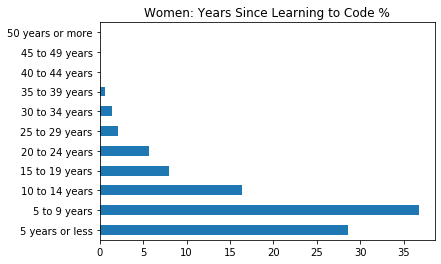

In [169]:
bar_plot_percent('YearsCodeR', 'barh', 'Women: Years Since Learning to Code %', order=categories_years, df=df_ds[df_ds['Gender'] == 'Woman']);

In [170]:
get_percent('YearsCodeR', df=df_ds[df_ds['Gender'] == 'Woman'])

5 to 9 years       36.86
5 years or less    28.70
10 to 14 years     16.45
15 to 19 years      8.04
20 to 24 years      5.74
25 to 29 years      2.17
30 to 34 years      1.40
35 to 39 years      0.64
Name: YearsCodeR, dtype: float64

**There aren't female Data Scientists with more of 40 since learned to code**, and **only ~10% did it 20 or more years ago**. This may be related to the historical problem of retention of women in the Tech Industry and STEM disciplines.

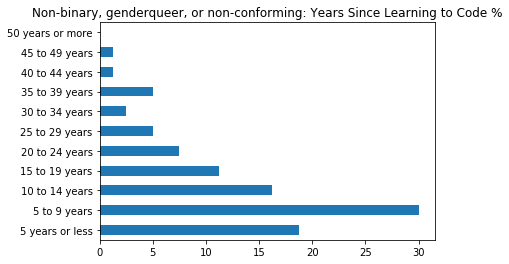

In [171]:
bar_plot_percent('YearsCodeR', 'barh', 'Non-binary, genderqueer, or non-conforming: Years Since Learning to Code %', order=categories_years, df=df_ds[df_ds['Gender'] == 'Non-binary, genderqueer, or gender non-conforming']);

In [172]:
get_percent('YearsCodeR', df_ds[df_ds['Gender'] == 'Non-binary, genderqueer, or gender non-conforming'])

5 to 9 years       30.38
5 years or less    18.99
10 to 14 years     16.46
15 to 19 years     11.39
20 to 24 years      7.59
35 to 39 years      5.06
25 to 29 years      5.06
30 to 34 years      2.53
40 to 44 years      1.27
45 to 49 years      1.27
Name: YearsCodeR, dtype: float64

Interestingly, **~23% of Non-binary, genderqueer, or non-conforming Data Scientists report 20 or more years of coding experience**, slighly lower than males. Nonetheles, is important to remember that females and gender minorities are very small portion of the sample, so caution must me taken when interpreting this numbers.

#### Sexual Orientation

In [173]:
df_ds.Sexuality.unique()

array(['Straight / Heterosexual', nan, 'Bisexual', 'Gay or Lesbian',
       'Bisexual;Straight / Heterosexual',
       'Bisexual;Gay or Lesbian;Straight / Heterosexual',
       'Bisexual;Gay or Lesbian',
       'Gay or Lesbian;Straight / Heterosexual'], dtype=object)

In [174]:
df_ds.Sexuality.replace({
    'Bisexual;Straight / Heterosexual': 'Bisexual',
    'Bisexual;Gay or Lesbian;Straight / Heterosexual': 'Bisexual',
    'Bisexual;Gay or Lesbian': 'Bisexual',
    'Gay or Lesbian;Straight / Heterosexual': 'Bisexual'
}, inplace=True)

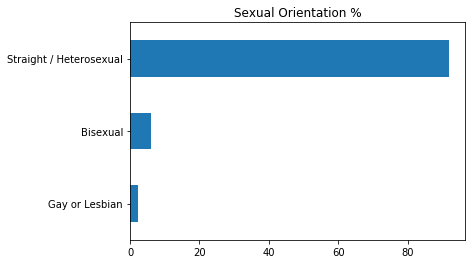

In [175]:
bar_plot_percent('Sexuality', 'barh', 'Sexual Orientation %', sort=True);

In [176]:
get_percent('Sexuality')

Straight / Heterosexual    91.89
Bisexual                    5.90
Gay or Lesbian              2.21
Name: Sexuality, dtype: float64

Around **8% of the sample report to seld-identify as Bisexual, Gay, or Lesbian**. Since this is a world-wide survey, it is hard to have a reference point. For instance, in the US there are report suggesting that around 4.5~ are LGBT. 

#### Disability Status
Unfortunately, this feature is absent in the dataset

#### Age

In [177]:
conditions_a = [
    (df_ds['Age'] < 15),
    (df_ds['Age'] >= 15) & (df_ds['Age'] <= 19),
    (df_ds['Age'] >= 20) & (df_ds['Age'] <= 24),
    (df_ds['Age'] >= 25) & (df_ds['Age'] <= 29),
    (df_ds['Age'] >= 30) & (df_ds['Age'] <= 34),
    (df_ds['Age'] >= 35) & (df_ds['Age'] <= 39),
    (df_ds['Age'] >= 40) & (df_ds['Age'] <= 44),
    (df_ds['Age'] >= 45) & (df_ds['Age'] <= 49),
    (df_ds['Age'] >= 50) & (df_ds['Age'] <= 54),
    (df_ds['Age'] >= 55) & (df_ds['Age'] <= 59),
    (df_ds['Age1stCode'] >= 60)
    ]

categories_a = [
    'Younger than 15 years', '15 to 19 years', '20 to 24 years', 
    '25 to 29 years','30 to 34 years', '35 to 39 years', '40 to 44 years', 
    '45 to 49 years', '50 to 54 years','55 to 59 years', '60 years and older'
    ]

df_ds['AgeR'] = np.select(conditions_a, categories_a)

In [178]:
df_ds.AgeR.replace({'0': np.nan}, inplace=True)

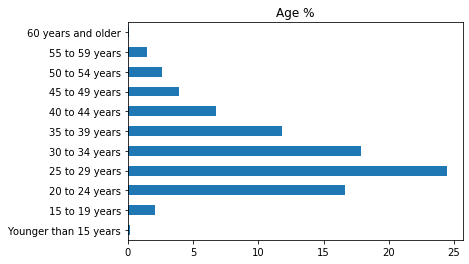

In [179]:
bar_plot_percent('AgeR', 'barh', 'Age %', order=categories_a);

In [180]:
get_percent('AgeR')

25 to 29 years           27.86
30 to 34 years           20.37
20 to 24 years           18.92
35 to 39 years           13.44
40 to 44 years            7.70
45 to 49 years            4.44
50 to 54 years            2.97
15 to 19 years            2.34
55 to 59 years            1.67
Younger than 15 years     0.21
60 years and older        0.09
Name: AgeR, dtype: float64

People in Data Science, as in Tech, tend to be young: **~50% is 29 or younger**, and **~70% is 35 or younger**. Compare this with the [11% of physicians younger than 35% in the US](https://www.statista.com/statistics/415961/share-of-age-among-us-physicians/). True, becoming a physician takes longer than becoming a Data Scientist (in general), but remember that most Data Scientists have advance degrees MA and PhD. Part of this may be explained by the obvious fact that the Data/Tech industry has blossomed very recently compared to the Medical profession. In any case, the fact is that **if you get into Data Science, you will be confronting a very young demographic work environment and pool of competitors.**

#### Average Age by Country

In the Stack Overflow survey they decided to use bar plots for this. I'll go with a bubble map, since is a more compact and fair representation (no country exclusions)

In [182]:
countries_plot_3 = countries_plot_2.merge(df_ds.groupby('Country')['Age'].mean(), left_index=True, right_index=True)

In [183]:
countries_plot_3.dropna(inplace=True)

In [184]:
fig = px.scatter_geo(countries_plot_3, locations="iso_alpha",
                     hover_name="countries", size="Age", color="Age",
                     projection="natural earth")
fig.show()

Fiji has the highest average age! and it also happens to have a sample size of 2, so you probable want to look at this plot very carefully. 

#### Average Years of Coding Experience by Country

In [185]:
countries_plot_4 = countries_plot_3.merge(df_ds.groupby('Country')['YearsCode'].mean(), left_index=True, right_index=True)

In [186]:
countries_plot_4.dropna(inplace=True)

In [187]:
fig = px.scatter_geo(countries_plot_4, locations="iso_alpha",
                     hover_name="countries", size="YearsCode", color="YearsCode",
                     projection="natural earth")
fig.show()

Data Scientists from **Africa, the Middle East, and Eastern Europe, tend to have less years of experience**, whereas Data Scientists from **Western Europe, the US, Canada, Australia, and New Zealand tend to have more**. Keep in mind that the sample for most countries is very small. 

### Evaluating Competence

#### All of the Developers Are Above Average?

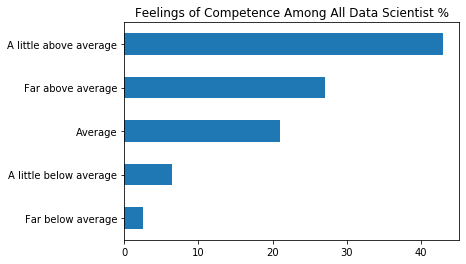

In [188]:
bar_plot_percent('ImpSyn', 'barh', 'Feelings of Competence Among All Data Scientist %', sort=True);

In [189]:
get_percent('ImpSyn')

A little above average    42.98
Far above average         27.07
Average                   20.94
A little below average     6.46
Far below average          2.55
Name: ImpSyn, dtype: float64

**~70% of respondents think they are above average and ~9% below average**. Confidence is bit higher than for all developers (~66%), but in general looks like the vast majority of Data Scientists think to be better than the average. The Stack Overflow team seems to think that this is a measure of 'impostor syndrome' (given the variable name). Even though 'impostor syndrome' technically is not some form of psychopathology, I have a few ideas of how to measure that 'construct' more accurately.

#### Feelings of (High) Competence By Gender

In [190]:
totals_by_gender = df_ds.groupby('Gender2')['ImpSyn'].count().values
percent_by_gender_high = df_ds[(df_ds.ImpSyn == 'Far above average') | (df_ds.ImpSyn == 'A little above average')].groupby('Gender2')['ImpSyn'].count() / totals_by_gender

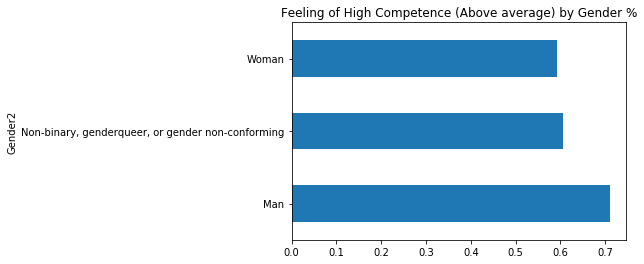

In [191]:
percent_by_gender_high.plot(kind='barh', title= "Feeling of High Competence (Above average) by Gender %");

In [192]:
percent_by_gender_high

Gender2
Man                                                  0.711578
Non-binary, genderqueer, or gender non-conforming    0.606061
Woman                                                0.591331
Name: ImpSyn, dtype: float64

Looking at feelings of competence by gender, mens are at the top with **~71% thinkin they are better than average**. Women and Non-binary, genderqueer, or gender non-conforming individuals think the same but in a lesser extent.

#### Feelings of (Low) Competence by Gender

In [193]:
percent_by_gender_low = df_ds[(df_ds.ImpSyn == 'Far below average') | (df_ds.ImpSyn == 'A little below average')].groupby('Gender2')['ImpSyn'].count() / totals_by_gender

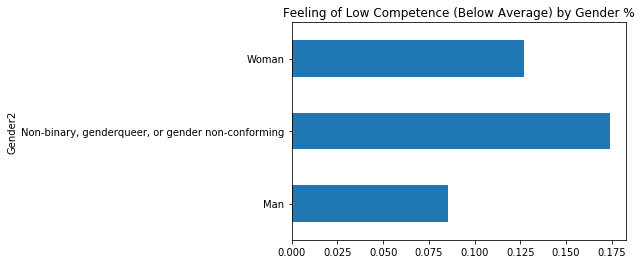

In [194]:
percent_by_gender_low.plot(kind='barh', title= "Feeling of Low Competence (Below Average) by Gender %");

In [195]:
percent_by_gender_low

Gender2
Man                                                  0.085218
Non-binary, genderqueer, or gender non-conforming    0.174242
Woman                                                0.126935
Name: ImpSyn, dtype: float64

Even more notorious is the gap in feeling less competente than average: **only 8.5% of men report to think they are below average**. Both women and non-binary, genderqueer, or gender non-conforming report more than men, with 12.6% and 17.4%, respectively.

### Life Outside Work

#### Children and Other Dependents

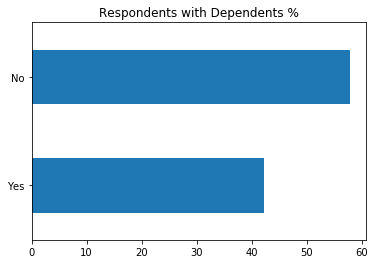

In [196]:
bar_plot_percent('Dependents', 'barh', 'Respondents with Dependents %', sort=True);

In [197]:
get_percent('Dependents')

No     57.89
Yes    42.11
Name: Dependents, dtype: float64

Near 42% of respondents report to have some type of dependent.

#### Families and IT Support

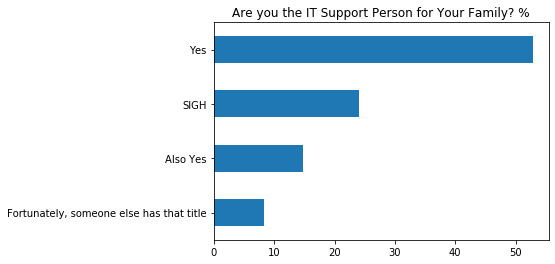

In [198]:
bar_plot_percent('ITperson', 'barh', 'Are you the IT Support Person for Your Family? %', sort=True);

Interestingly, most Data Scientists also have the title of IT person of their families.

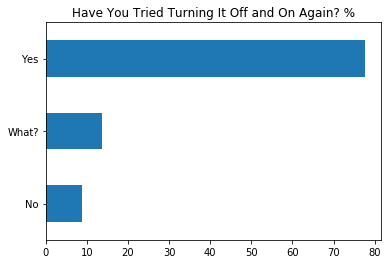

In [199]:
bar_plot_percent('OffOn', 'barh', 'Have You Tried Turning It Off and On Again? %', sort=True);

#### Will People Born Today Have a Better Life Than Their Parents?

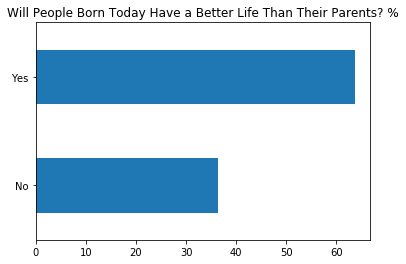

In [200]:
bar_plot_percent('BetterLife', 'barh', 'Will People Born Today Have a Better Life Than Their Parents? %', sort=True);

In [201]:
get_percent('BetterLife')

Yes    63.61
No     36.39
Name: BetterLife, dtype: float64

Roughly 2 of every 3 Data Scientists think that people born today will have a better life than their parents (Climate change beg to disagree)

#### Social Media Use

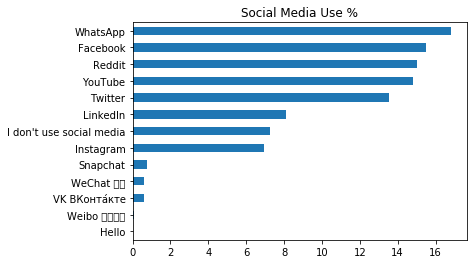

In [202]:
bar_plot_percent('SocialMedia', 'barh', 'Social Media Use %', sort=True);

The top 3 primary social media platforms for Data Science are WhatsApp, Facebook, and Reddit. For all respondents, this was Reddit, YouTube, and WhatsApp.

#### What's Your Handle?

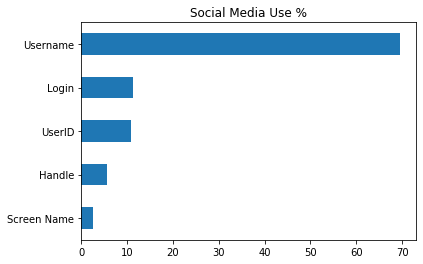

In [203]:
bar_plot_percent('ScreenName', 'barh', 'Social Media Use %', sort=True);

#### IRL or online chat?

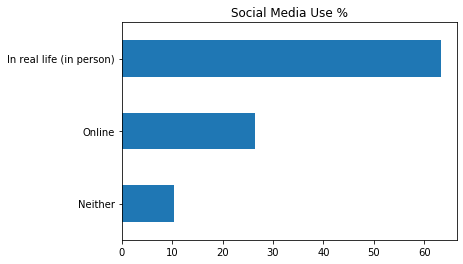

In [204]:
bar_plot_percent('Extraversion', 'barh', 'Social Media Use %', sort=True);

**~11% of Data Scientists don't want to communicate at all with anyone**. For some reason, the Stack Overflow team thinks that this is a measure of extra version. Personality psychologist aren't particularly happy with that.

## 5. Key Observations and Conclusions

Let's summarize our findings in **10 key insights about Data Scientist's profile in the Stack Overflow Survey (2019)**:

1. **~37%** of Data Scientists report to contribute to open source more than once per year, and 13.37% once a month or more often. 
2. **~81%** of Data Scientists report to code as a hobby.
3. **~47%** of Data Scientists report having learned to code in the last 9 years.
4. **~18%** of Data Scientists report less than 5 years of coding professionally.
5. **~68%** of Data Scientists mentioned that they wrote that *first line of code* as kids (i.e., 17 years or less).
6. **~27%** of Data Scientists report to be part-time or full time student. 
7. **Data Scientist are highly educated**: **~81%** have BA or higher,**~42%** have MA or higher, and **~10%** professional degrees and PhD. This is sharp contrast with developers in general who report ~72%, ~26%, and ~4%, respectively.
8. Data Scientists of white and european ancestry dominate the sample with **70%**, followed by people from south asia (mostly from India) with **12.57%**.
9. **~91%** of Data Scientists are males
10. **~8%** of Data Scientists report to self-identify as Bisexual, Gay, or Lesbian.
11. Data Scientists tend to be young: **~50%** is 29 or younger, and **~70%** is 35 or younger.
12. **~70%** of Data Scientists think they are above average and only **~9%** below average. 
13. **~8.5%** of men report to think they are below average; Women report **~12.6%**; Non-binary, genderqueer, or gender non-conforming report **17.4%**.
14. **~63%** of Data Scientists think that people born today will have a better life than their parents.
15. The top 3 primary social media platforms for Data Scientists are **WhatsApp, Facebook, and Reddit**.


**Bonus: ~11% of Data Scientists don't want to communicate with anyone at all**
